# This is your playground! Leaderboard를 정복해 주세요!

In [122]:
import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 데이터 불러오기

In [123]:
data_path = '/content/drive/MyDrive/AIFFEL/Exp/04/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 데이터 탐색하기



*   변수(Column) 정리



In [124]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

y = train['price']
del train['price']

del train['id']
del test['id']



*   결측치 확인



In [125]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0




*   목적(target) 변수 분포도



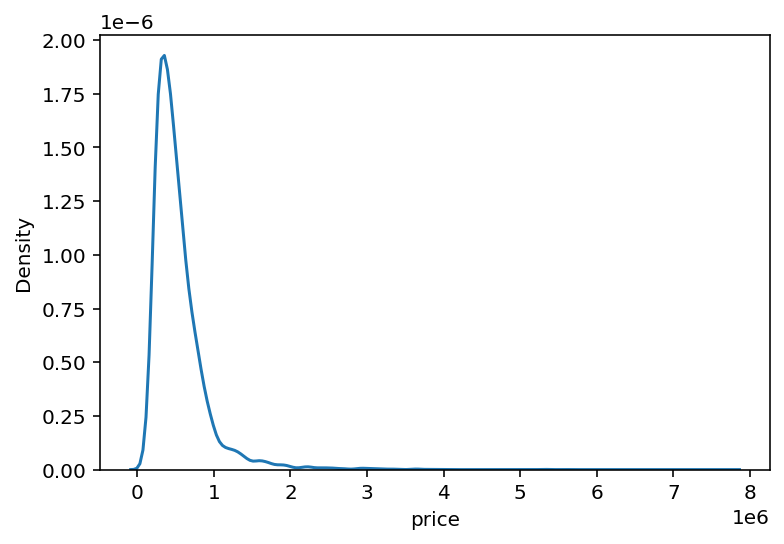

In [126]:
sns.kdeplot(y)
plt.show()



*   정규화(Normalization) --> 로그 변환



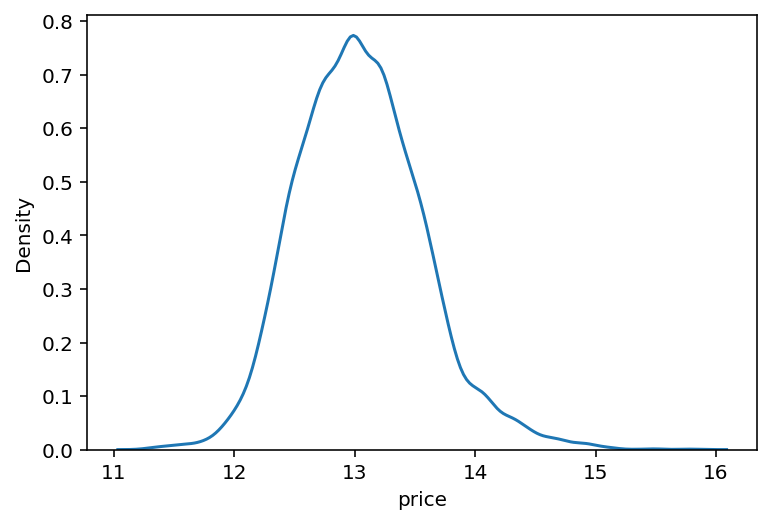

In [127]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

### 모델 선정 : LGBM

In [129]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [130]:
gboost = GradientBoostingRegressor(random_state=4)
xgboost = XGBRegressor(random_state=4)
lightgbm = LGBMRegressor(random_state=4)
rdforest = RandomForestRegressor(random_state=4)

models = [gboost, xgboost, lightgbm, rdforest]

In [131]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=4, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

[12:10:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
GradientBoostingRegressor,142994.839258
RandomForestRegressor,142030.259246
XGBRegressor,141169.647904
LGBMRegressor,112327.574110


### 파라미터 설정 : max_depth=10, n_estimators=100

In [132]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(train, y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['RMSLE'] = np.sqrt(-1 * score)
    results = results.sort_values('RMSLE')

    return results

In [133]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=4)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,RMSLE
3,10,100,0.164399
2,10,50,0.170814
1,1,100,0.234564
0,1,50,0.270914


### 모델 학습 및 예측

In [134]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=4)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

### 결과 제출

In [135]:
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [136]:
submission['price'] = prediction
submission.to_csv(data_path + 'submission.csv', index=False)

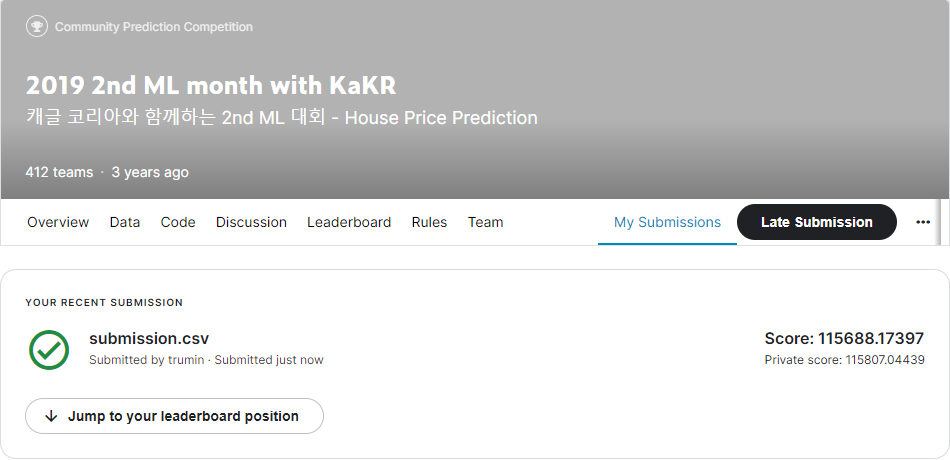

### 회고

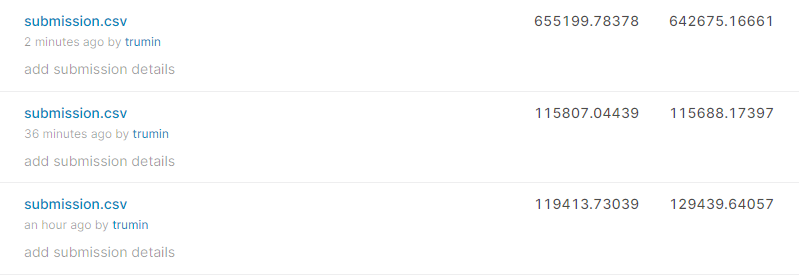



*   데이터 정규화 실패



전체 column에 대하여 데이터 분포도를 조사했을 때 target인 'price'를 포함해 6개 column들의 데이터 분포가 한 쪽으로 크게 치우쳐 있었다. 따라서 이들을 로그 변환하여 정규화한 데이터로 모델을 학습시켰다. 그러나 그 결과는 참담했다. [655199] 결국 target 'price'를 제외한 나머지 column들은 로그 변환으로부터 원상 복구했고 어느 정도 납득할만한 결과를 얻을 수 있었다. target이 아닌 다른 column들을 정규화했을 때 이들을 학습시키는 과정 또는 그 이후에 이들을 다시 원래의 scale로 복구시켜야 하는 부분이 필요한 것으로 판단된다.



*   파라미터 튜닝의 강력함



여러 모델들의 결과를 취합하는 앙상블 기법을 사용했을 때[119413]보다 한 가지 모델(LGBM)에 대하여 최적화된 파라미터를 찾아 적용시키는 방식[115807]이 조금 더 좋은 결과를 얻을 수 있었다. 앙상블 기법을 사용할 때도 역시 최적화된 파라미터를 사용했다면 더 좋은 결과를 얻을 수 있었을 것이다.